In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import AdamW

df = pd.read_csv("../../data/csv/cleaned_fix.csv")

df_filtered = df[df['experience'].isin(['FirstYear', 'CSI'])]

selected_columns = ["Image", "Scene", "ROI", "FixDur", "FixNr", "Start", "End", "X", "Y", "Participant", "experience"]
df_filtered =  df_filtered[selected_columns]

2025-06-02 17:24:58.419779: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 17:24:58.429222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748877898.439788  435638 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748877898.443590  435638 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748877898.451474  435638 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
len(df)

30135

In [3]:
df_filtered.sort_values(by=['Participant', 'FixNr'], inplace=True)

In [4]:
# Sum FixNr per participant within each experience group
participant_fixnr = df_filtered.groupby(['experience', 'Participant'])['FixNr'].sum().reset_index()

# For each experience group, get the participant with the lowest FixNr
lowest_fixnr_participants = participant_fixnr.loc[participant_fixnr.groupby('experience')['FixNr'].idxmin()]

# Extract the participant IDs for the test set
test_participants = lowest_fixnr_participants['Participant'].values

test_df = df_filtered[df_filtered['Participant'].isin(test_participants)]
train_df = df_filtered[~df_filtered['Participant'].isin(test_participants)]

In [5]:
test_participants

array([1012.,   16.])

In [6]:
test_df['Participant'].unique()


array([  16., 1012.])

In [7]:
train_df['Participant'].unique()

array([   4.,   12.,   20.,   23.,   24.,   28.,   29.,   30., 1010.,
       1011., 1013., 1014., 1017., 1018., 1019., 1020.])

In [8]:
features = ["Image", "Scene", "ROI", "FixDur", "FixNr", "Start", "End", "X", "Y"]
label_col = 'experience'

In [9]:
X_train_raw = train_df[features]
y_train_raw = train_df[label_col]
X_test_raw = test_df[features]
y_test_raw = test_df[label_col]

In [10]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_raw)
y_test_encoded = label_encoder.transform(y_test_raw)
y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

In [12]:
# --- Sliding window function ---
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size+1):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size - 1])  # predict last item in window
    return np.array(X_seq), np.array(y_seq)

In [13]:
window_size = 5  # adjust as needed
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_onehot, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_onehot, window_size)

In [14]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = Sequential([
    LSTM(2, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.5),
    BatchNormalization(),
    LSTM(8),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train ---
history = model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.1)

Epoch 1/200


W0000 00:00:1748877901.174674  435638 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5180 - loss: 0.7855 - val_accuracy: 0.3805 - val_loss: 0.7375
Epoch 2/200
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5610 - loss: 0.6985 - val_accuracy: 0.3646 - val_loss: 0.7353
Epoch 3/200
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5660 - loss: 0.6821 - val_accuracy: 0.4708 - val_loss: 0.7171
Epoch 4/200
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5816 - loss: 0.6723 - val_accuracy: 0.5191 - val_loss: 0.6983
Epoch 5/200
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5834 - loss: 0.6729 - val_accuracy: 0.5646 - val_loss: 0.6925
Epoch 6/200
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5803 - loss: 0.6680 - val_accuracy: 0.5921 - val_loss: 0.6786
Epoch 7/200
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6097 - loss: 0.6584 - val_accuracy: 0.5791 - val_loss: 0.6970
Epoch 8/200
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6021 - loss: 0.6509 - val_accuracy: 0.6123

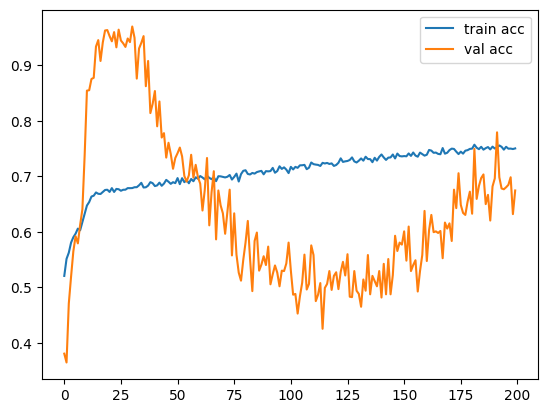

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [16]:
# --- Evaluate ---
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Accuracy: {test_acc:.2f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6200 - loss: 0.7014 
Test Accuracy: 0.39


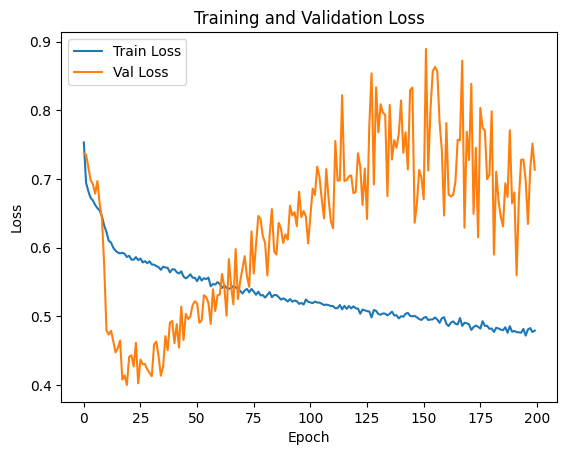

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


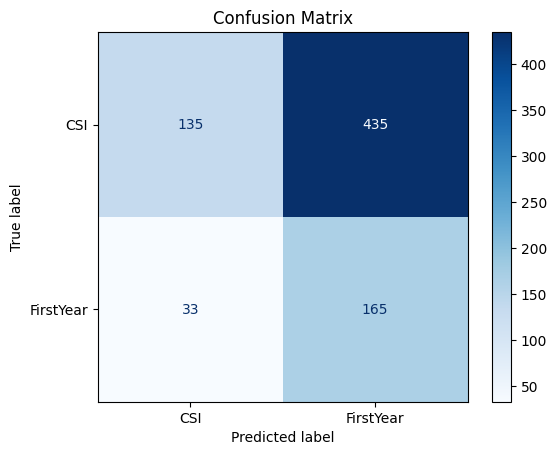

In [18]:
# --- Predict on test set ---
y_pred_probs = model.predict(X_test_seq)                     # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)                 # Convert to class indices
y_true = np.argmax(y_test_seq, axis=1)                       # Convert one-hot to class indices

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [19]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

         CSI       0.80      0.24      0.37       570
   FirstYear       0.28      0.83      0.41       198

    accuracy                           0.39       768
   macro avg       0.54      0.54      0.39       768
weighted avg       0.67      0.39      0.38       768



In [20]:
import shap

timesteps = X_train_seq.shape[1]
feature_size = X_train_seq.shape[2]

# Flatten over time for KernelExplainer input (required to make it 2D)
background = X_train_seq[:100].mean(axis=1)  # shape: (100, features)

# Define prediction function that reshapes 2D input back to 3D for the LSTM
def predict_fn(x):
    x_reshaped = x.reshape((x.shape[0], 1, feature_size))  # reshape to (batch, 1, features)
    return model.predict(x_reshaped)

explainer = shap.KernelExplainer(predict_fn, background)

# Flatten test samples too
X_test_flat = X_test_seq[:10].mean(axis=1)  # shape: (10, features)

# Explain predictions
shap_values = explainer.shap_values(X_test_flat)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|                                                    | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step


 10%|████▍                                       | 1/10 [00:01<00:09,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step


 20%|████████▊                                   | 2/10 [00:02<00:08,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step


 30%|█████████████▏                              | 3/10 [00:03<00:07,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step


 40%|█████████████████▌                          | 4/10 [00:04<00:06,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step


 50%|██████████████████████                      | 5/10 [00:05<00:05,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step


 60%|██████████████████████████▍                 | 6/10 [00:06<00:03,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step


 70%|██████████████████████████████▊             | 7/10 [00:07<00:02,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step


 80%|███████████████████████████████████▏        | 8/10 [00:08<00:01,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step


 90%|███████████████████████████████████████▌    | 9/10 [00:09<00:00,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step


100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.00s/it]


In [21]:
# Assume: shap_values has shape (samples, features, classes)
n_classes = shap_values.shape[2]
feature_names = features  # or manually define if needed

for class_idx in range(n_classes):
    print(f"\nTop features for class {label_encoder.classes_[class_idx]}")
    
    # Take absolute SHAP values for the given class and average over samples
    class_shap = np.abs(shap_values[:, :, class_idx]).mean(axis=0)  # shape: (features,)
    
    top_features = pd.Series(class_shap, index=feature_names).sort_values(ascending=False)
    print(top_features)


Top features for class CSI
FixNr     0.003656
Scene     0.002974
Start     0.002696
End       0.001806
X         0.000391
Y         0.000165
Image     0.000121
FixDur    0.000050
ROI       0.000006
dtype: float64

Top features for class FirstYear
FixNr     0.003656
Scene     0.002974
Start     0.002696
End       0.001806
X         0.000391
Y         0.000165
Image     0.000121
FixDur    0.000050
ROI       0.000006
dtype: float64
